In [1]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import causallearn

from causallearn.utils.cit import *
from causallearn.graph.GraphClass import CausalGraph
import pandas as pd
from itertools import combinations, combinations_with_replacement, permutations, product
from numpy import ndarray
from typing import Dict, List, Tuple
from causallearn.utils.cit import fisherz
import random
import itertools

import time

import scipy as sp
from scipy.stats import beta

import pandas as pd

from statsmodels.distributions.empirical_distribution import ECDF


# Traffic Model:

## Test

In [2]:
N = 1000
T = 500
x_eq = 100
mu = 0.3
mu_acc = 0.2
time_duration_acc = 2
noise_range = 10
p_acc = 0.01
beta = 0.01
num_links = 3

In [3]:
ctrl = mu * x_eq * num_links
noise_array = np.random.rand(N, T, num_links) * 2 * noise_range - noise_range
x_array_H0 = np.zeros((N, T, num_links))
# x_0 = np.random.rand(N) * 2 * noise_range - noise_range + 0.5 * x_eq
x_0 = np.random.rand(N, num_links) * 2 * noise_range - noise_range + 1 * x_eq

acc_vec = np.random.binomial(1, p = p_acc, size = (N, T))

high_load_threshold_ratio = 0.9
high_load_threshold = x_eq + high_load_threshold_ratio * noise_range
counter = 0
    
# Frank: To edit below:

x_array_H0[:, 0, :] = x_0
for i in range(N):
    for t in range(T-1):
        sum_flow_measures = sum([np.exp(- beta * x_array_H0[i, t, k]) for k in list(range(num_links)) ])
        ratio_flow_measures = np.exp(- beta * x_array_H0[i, t, :]) / sum_flow_measures
#         ratio_flow_measures = 1/3
        
        if t == 0:
            x_array_H0[i, t+1, :] = (1 - mu) * x_array_H0[i, t, :] + ctrl * ratio_flow_measures + noise_array[i, t, :]
            counter = 0
        elif np.any(acc_vec[i, t] == 1):
            x_array_H0[i, t+1, :] = (1 - mu_acc) * x_array_H0[i, t, :] + ctrl * ratio_flow_measures + noise_array[i, t, :]
            break
        else:
            x_array_H0[i, t+1, :] = (1 - mu) * x_array_H0[i, t, :] + ctrl * ratio_flow_measures + noise_array[i, t, :]


In [4]:
x_array_H0[0, 0:10, :]

array([[ 97.31046827, 101.12830173,  98.49259778],
       [ 97.50951405, 108.77847565, 103.3591105 ],
       [109.6736476 ,  99.55808345, 106.21630572],
       [100.84859863,  99.57785841,  97.77045114],
       [107.38565713,  95.17875234,  96.65854706],
       [ 99.92043721,  96.47786595,  93.29138563],
       [105.4435132 , 107.20334934, 105.55470528],
       [113.23360358, 105.45839867, 109.29325925],
       [109.01134389,  98.07377695, 113.26929907],
       [108.93853487, 100.58190988, 105.25633581]])

In [5]:
np.any(np.array([1, 0, 1]) == 0)

True

## Functions

In [25]:
# Preliminary code, only for generating results related to first-time accident incidents.

def generate_H0_data_multidim(N, T, x_eq = 100, mu = 0.3, mu_acc = 0.2, time_duration_acc = 2, noise_range = 10, \
                     p_acc = 0.02, beta = 0.05, num_links = 2):

    ctrl = mu * x_eq * num_links
    noise_array = np.random.rand(N, T, num_links) * 2 * noise_range - noise_range
    x_array_H0 = np.zeros((N, T, num_links))
    # x_0 = np.random.rand(N) * 2 * noise_range - noise_range + 0.5 * x_eq
    x_0 = np.random.rand(N, num_links) * 2 * noise_range - noise_range + 1 * x_eq

    acc_vec = np.random.binomial(1, p = p_acc, size = (N, T))

    high_load_threshold_ratio = 0.9
    high_load_threshold = x_eq + high_load_threshold_ratio * noise_range
    counter = 0
    
    # Frank: To edit below:

    x_array_H0[:, 0, :] = x_0
    for i in range(N):
        for t in range(T-1):
            sum_flow_measures = sum([np.exp(- beta * x_array_H0[i, t, k]) for k in list(range(num_links)) ])
            ratio_flow_measures = np.exp(- beta * x_array_H0[i, t, :]) / sum_flow_measures
#             ratio_flow_measures = 1/3
            
            if t == 0:
                x_array_H0[i, t+1, :] = (1 - mu) * x_array_H0[i, t, :] + ctrl * ratio_flow_measures + noise_array[i, t, :]
                counter = 0
            elif np.any(acc_vec[i, t] == 1):
                break
            else:
                x_array_H0[i, t+1, :] = (1 - mu) * x_array_H0[i, t, :] + ctrl * ratio_flow_measures + noise_array[i, t, :]

    return x_array_H0, acc_vec


def generate_H1_data_multidim(N, T, x_eq = 100, mu = 0.3, mu_acc = 0.2, time_duration_acc = 2, noise_range = 10, \
                     p_acc = 0.02, p_acc_high_load = 0.2, beta = 0.01, num_links = 2, high_load_threshold_ratio = 0.8):
    
    ctrl = mu * x_eq * num_links
    noise_array = np.random.rand(N, T, num_links) * 2 * noise_range - noise_range
    x_array_H1 = np.zeros((N, T, num_links))
    # x_0 = np.random.rand(N) * 2 * noise_range - noise_range + 0.5 * x_eq
    x_0 = np.random.rand(N, num_links) * 2 * noise_range - noise_range + 1 * x_eq

    acc_vec = np.random.binomial(1, p = p_acc, size = (N, T))
    acc_vec_high_load = np.random.binomial(1, p = p_acc_high_load, size = (N, T))
    acc_realized_H1 = np.zeros((N, T))

    high_load_threshold = x_eq + high_load_threshold_ratio * noise_range
#     print("high_load_threshold:", high_load_threshold)
    counter = 0

    x_array_H1[:, 0, :] = x_0
    for i in range(N):
        for t in range(T-1):
            sum_flow_measures = sum([np.exp(- beta * x_array_H1[i, t, k]) for k in list(range(num_links)) ])
            ratio_flow_measures = np.exp(- beta * x_array_H1[i, t, :]) / sum_flow_measures
#             ratio_flow_measures = 1/3
            
            if t == 0:
                acc_realized_H1[i, t] = 0 
                x_array_H1[i, t+1, :] = (1 - mu) * x_array_H1[i, t, :] + ctrl * ratio_flow_measures + noise_array[i, t, :]
            elif np.all(x_array_H1[i, t, :] <= high_load_threshold) and acc_vec[i, t] == 1:
                acc_realized_H1[i, t] = 1
                break
            elif np.any(x_array_H1[i, t, :] > high_load_threshold) and acc_vec_high_load[i, t] == 1:
                acc_realized_H1[i, t] = 1
                break
            else:
                acc_realized_H1[i, t] = 0
                x_array_H1[i, t+1, :] = (1 - mu) * x_array_H1[i, t, :] + ctrl * ratio_flow_measures + noise_array[i, t, :]

    
    return x_array_H1, acc_realized_H1


In [24]:
def generate_data_processed_dict_multidim(x_array, acc_realized):
    
    assert x_array.shape[0:2] == acc_realized.shape
    N = x_array.shape[0]
    T = x_array.shape[1]
    
    first_times_of_rare_event = np.zeros(N)
    for i in range(N):
    #     print(acc_realized[i, :].shape)
    #     print(np.zeros(T).shape)
        if (acc_realized[i, :] == np.zeros(T)).all() or acc_realized[i, 0] == 1:
            first_times_of_rare_event[i] = -1
        else:
    #     print(min([t for t in range(T) if acc_realized[i, t] == 1]))
            first_times_of_rare_event[i] = min([t for t in range(1,T) if acc_realized[i, t] == 1])
#             print("i:", i)
#             print("first_times_of_rare_event[i]:", first_times_of_rare_event[i])

    first_times_of_rare_event_as_set = set(list(first_times_of_rare_event))
    if -1 in first_times_of_rare_event_as_set:
        first_times_of_rare_event_as_set.remove(-1)
    first_times_of_rare_event_as_list = list(first_times_of_rare_event_as_set)

    # for first_time in first_times_of_rare_event_as_set:

    # first_times_of_rare_event_as_set

    x_processed_dict_XT = {}
    x_processed_dict_Xgen = {}
    first_times_dict = {}
    
    for time in first_times_of_rare_event_as_list:
    #     print(time)
        x_processed_dict_XT[time] = []
        x_processed_dict_Xgen[time] = []
        first_times_dict[time] = []
        for i in range(N):
            if first_times_of_rare_event[i] >= time:
                x_processed_dict_Xgen[time].append(x_array[i, int(time)-1, :])
            if first_times_of_rare_event[i] == time:
                first_times_dict[time].append(i)
                x_processed_dict_XT[time].append(x_array[i, int(time)-1, :])
    
    return x_processed_dict_XT, x_processed_dict_Xgen, first_times_dict

def generate_cdf_Xgen_multidim(x_processed_dict_Xgen, first_times_dict, N, T, \
                      x_lower_bound = 75.0, x_upper_bound = 125.0, x_values_length = 20, \
                      x_value_set_choice = 'Fixed', num_links = 2):
    assert list(x_processed_dict_Xgen.keys()) == list(first_times_dict.keys())
    
    x_values_jumps_Xgen = list(itertools.chain(*list(x_processed_dict_Xgen.values())))
#     print("x_values_jumps_Xgen:", x_values_jumps_Xgen)
#     print()
    
#     print("len(x_values_jumps_Xgen):", len(x_values_jumps_Xgen))
#     print("max(x_values_jumps_Xgen):", max(x_values_jumps_Xgen))
#     return
    
#     cdf_value_at_jumps_Xgen = []
    x_cdf_dict_Xgen = {}
    
    if x_value_set_choice == 'Fixed':
        x_value_array_per_link = np.linspace(x_lower_bound, x_upper_bound, x_values_length)
        if num_links == 3:
            x_value_array = list(product(x_value_array_per_link, x_value_array_per_link, x_value_array_per_link))
        elif num_links == 2:
            x_value_array = list(product(x_value_array_per_link, x_value_array_per_link))
        else:
            assert 1 == 0, "num_links needs to be 2 or 3, for now."
    elif x_value_set_choice == 'Jump values':
        x_value_array = x_values_jumps_Xgen
    else:
        assert 1 == 0, "Choose appropriate x_value_set_choice."
    
    for x_value in x_value_array:
        cdf_value_temp = 0
        for time in first_times_dict.keys():
#             print("x_value:", x_value)
#             print("x_processed_dict_Xgen[time][0]:", x_processed_dict_Xgen[time][0])
#             print("x_processed_dict_Xgen[time]:", x_processed_dict_Xgen[time])
            cdf_value_temp += len([x_val for x_val in x_processed_dict_Xgen[time] if np.all(x_val <= np.array(x_value) )])/len(x_processed_dict_Xgen[time]) \
                                * len(first_times_dict[time])/N
#         cdf_value_at_jumps_Xgen.append(cdf_value_temp)
        x_cdf_dict_Xgen[x_value] = cdf_value_temp
    
    return x_values_jumps_Xgen, x_cdf_dict_Xgen


def generate_cdf_XT_multidim(x_processed_dict_XT, first_times_dict, N, T, \
                      x_lower_bound = 75.0, x_upper_bound = 125.0, x_values_length = 20, \
                      x_value_set_choice = 'Fixed', num_links = 2):
    assert list(x_processed_dict_XT.keys()) == list(first_times_dict.keys())
    
    x_values_jumps_XT = list(itertools.chain(*list(x_processed_dict_XT.values())))
    x_cdf_dict_XT = {}
    
#     print("x_values_jumps_XT:", x_values_jumps_XT)
    
    # Sort x_values_jumps_XT
    assert len(x_values_jumps_XT) <= N
    
#     print("len(x_values_jumps_XT):", len(x_values_jumps_XT))
#     print("max(x_values_jumps_XT):", max(x_values_jumps_XT))
        
    cdf_value_at_jumps_XT = []
    if x_value_set_choice == 'Fixed':
#         x_value_array = np.linspace(x_lower_bound, x_upper_bound, x_values_length)
        x_value_array_per_link = np.linspace(x_lower_bound, x_upper_bound, x_values_length)
        if num_links == 3:
            x_value_array = list(product(x_value_array_per_link, x_value_array_per_link, x_value_array_per_link))
        elif num_links == 2:
            x_value_array = list(product(x_value_array_per_link, x_value_array_per_link))
        else:
            assert 1 == 0, "num_links needs to be 2 or 3, for now."
    elif x_value_set_choice == 'Jump values':
        x_value_array = x_values_jumps_XT
    else:
        assert 1 == 0, "Choose appropriate x_value_set_choice."
        
#     print(len(x_value_array), "\n")
#     print(x_value_array)
#     print("x_values_jumps_XT:", x_values_jumps_XT)
    print("\n")

    for x_value in x_value_array:
#         print(len([x_val for x_val in x_values_jumps_XT if np.all(x_val <= np.array(x_value))]) / len(x_values_jumps_XT) ) 
#         print("x_value:", x_value)
        cdf_value_temp = len([x_val for x_val in x_values_jumps_XT if np.all(x_val <= np.array(x_value)) ]) \
                                     / len(x_values_jumps_XT)
        cdf_value_at_jumps_XT.append(cdf_value_temp)
        x_cdf_dict_XT[x_value] = cdf_value_temp
    
    return x_values_jumps_XT, x_cdf_dict_XT
    
def cdf_value(x, x_cdf_dict):
    key_list = [x_val for x_val in x_cdf_dict.keys() if x_val <= x]
    if key_list != []:
        dict_key = max(key_list)
    else:
        dict_key = min(x_cdf_dict.keys())
    return x_cdf_dict[dict_key]

def compare_CDFs(x_cdf_dict_1, x_cdf_dict_2, x_lower_bound = 75.0, x_upper_bound = 125.0, x_values_length = 20,\
                 x_value_set_choice = 'Jump values'):

    if x_value_set_choice == 'Jump values':
        assert x_cdf_dict_1.keys() == x_cdf_dict_2.keys()
#         print("x_cdf_dict_1.values():", x_cdf_dict_1.values())
        x_cdf_dict_1_values = np.array(list(x_cdf_dict_1.values()))
        x_cdf_dict_2_values = np.array(list(x_cdf_dict_2.values()))
        error_list = [abs(error) for error in x_cdf_dict_1_values - x_cdf_dict_2_values]
    elif x_value_set_choice == 'Fixed':
        error_list = []
        for x_value in np.linspace(x_lower_bound, x_upper_bound, x_values_length+1):
            error = abs(cdf_value(x_value, x_cdf_dict_1) - cdf_value(x_value, x_cdf_dict_2))
            error_list.append(error)
    else:
        assert 1 == 0, "Choose appropriate x_value_set_choice."
    
    return max(error_list)

def generate_cdf_array_generic_multidim(x_array, \
                      x_lower_bound = 75.0, x_upper_bound = 125.0, x_values_length = 20, \
                      x_value_set_choice = 'Fixed', num_links = 2):
    
    ## Currently, the "x_value_set_choice = 'Fixed'" option is broken.

#     print("len(x_values_jumps_XT):", len(x_values_jumps_XT))
#     print("max(x_values_jumps_XT):", max(x_values_jumps_XT))

    if x_value_set_choice == 'Fixed':
        x_value_array_per_link = np.linspace(x_lower_bound, x_upper_bound, x_values_length)
        if num_links == 3:
            x_value_array = list(product(x_value_array_per_link, x_value_array_per_link, x_value_array_per_link))
        elif num_links == 2:
            x_value_array = list(product(x_value_array_per_link, x_value_array_per_link))
        else:
            assert 1 == 0, "num_links needs to be 2 or 3, for now."
    elif x_value_set_choice == 'Jump values':
        x_value_array = x_array
    else:
        assert 1 == 0, "Choose appropriate x_value_set_choice."
    
    cdf_list = []
    
#     print("x_value_array[0]:", x_value_array[0])
#     print("x_array[0]:", x_array)
    
    for x_value in x_value_array:
        cdf_value_temp = len([x_val for x_val in x_array if np.all(x_val <= np.array(x_value)) ]) / len(x_array)
        cdf_list.append(cdf_value_temp)
    
    return cdf_list



## Single runs, test:

## Our Method

In [8]:
begin_time = time.time()

N = 1000
T = 200
number_of_links = 3
x_values_length_set = 10

x_array_H0, acc_realized_H0 = generate_H0_data_multidim(N, T, beta = 0.05, p_acc = 0.02, num_links = number_of_links)
x_array_H1, acc_realized_H1 = generate_H1_data_multidim(N, T, beta = 0.05, p_acc = 0.02, num_links = number_of_links, \
                                                        p_acc_high_load = 0.30, high_load_threshold_ratio = 0.5)

x_processed_dict_H0_XT, x_processed_dict_H0_Xgen, first_times_dict_H0 = \
    generate_data_processed_dict_multidim(x_array_H0, acc_realized_H0)
# print("x_processed_dict_H0_XT.values():", x_processed_dict_H0_XT.values())
print()
print(len(list(itertools.chain(*list(first_times_dict_H0.values()))))/N)

x_processed_dict_H1_XT, x_processed_dict_H1_Xgen, first_times_dict_H1 = \
    generate_data_processed_dict_multidim(x_array_H1, acc_realized_H1)

# print("x_processed_dict_H1_XT.values():", x_processed_dict_H1_XT.values())
print()
print(len(list(itertools.chain(*list(first_times_dict_H1.values()))))/N)

# print(list(itertools.chain(*list(x_processed_dict_H0_XT.values()))))

## To edit below:
print("H0, XT:")
x_values_jumps_H0_XT, x_cdf_dict_H0_XT = generate_cdf_XT_multidim(x_processed_dict_H0_XT, first_times_dict_H0, N, T, \
                                                                  num_links = number_of_links, x_values_length = x_values_length_set)
print("H0, Xgen:")
x_values_jumps_H0_Xgen, x_cdf_dict_H0_Xgen = generate_cdf_Xgen_multidim(x_processed_dict_H0_Xgen, first_times_dict_H0, N, T, \
                                                                        num_links = number_of_links, x_values_length = x_values_length_set)


print("H1, XT:")
x_values_jumps_H1_XT, x_cdf_dict_H1_XT = generate_cdf_XT_multidim(x_processed_dict_H1_XT, first_times_dict_H1, N, T, \
                                                                  num_links = number_of_links, x_values_length = x_values_length_set)
print("H1, Xgen:")
x_values_jumps_H1_Xgen, x_cdf_dict_H1_Xgen = generate_cdf_Xgen_multidim(x_processed_dict_H1_Xgen, first_times_dict_H1, N, T, \
                                                                        num_links = number_of_links, x_values_length = x_values_length_set)


end_time = time.time()
print("Time:", end_time - begin_time)



0.962

1.0
H0, XT:


H0, Xgen:
H1, XT:


H1, Xgen:
Time: 69.34749484062195


In [9]:
# x_values_jumps_H0_XT
x_processed_dict_H0_XT

# x_array_H1[5, :, :]

{1.0: [array([100.23809052, 101.48849467,  98.86402682]),
  array([ 97.05946189, 108.12053719, 105.70936151]),
  array([106.2595405 ,  90.82939012,  92.00435031]),
  array([ 93.44518795, 107.53524215,  97.71465474]),
  array([103.47190519, 102.91063342,  98.63067498]),
  array([ 98.74995337, 104.70881785, 107.31992481]),
  array([101.11929546,  92.25967161,  94.55073506]),
  array([ 92.57119991, 104.7708669 , 107.04350761]),
  array([102.29292606, 109.88966144,  97.06674196]),
  array([ 90.24687292,  91.98486687, 107.6305707 ]),
  array([102.83051425, 105.44673736, 108.53491936]),
  array([104.82774532, 102.85128822,  90.60050231]),
  array([ 93.55830923, 106.20215164,  92.97656758]),
  array([102.16762726, 109.05265418,  98.34931446]),
  array([101.35183118,  99.23691697,  99.38660524]),
  array([107.25432248, 103.6937053 , 106.42581159]),
  array([ 99.23330123, 109.72703172,  92.589136  ]),
  array([ 98.16634653,  96.47484546, 104.65513756]),
  array([ 95.03395278, 105.56235522,  91.

In [10]:
# x_processed_dict_H1_XT
# x_processed_dict_H0_XT

# x_array_H0
# x_array_H0[0, :, :]

print(compare_CDFs(x_cdf_dict_H0_XT, x_cdf_dict_H0_Xgen))
print(compare_CDFs(x_cdf_dict_H1_XT, x_cdf_dict_H1_Xgen))

0.03863114463538675
0.12447416437966619


In [11]:
print(compare_CDFs(x_cdf_dict_H0_XT, x_cdf_dict_H0_Xgen))
print(compare_CDFs(x_cdf_dict_H1_XT, x_cdf_dict_H1_Xgen))

0.03863114463538675
0.12447416437966619


## Naive Aggregation Method

In [12]:
x_values_length_set = 10

In [13]:
t_fixed = 0
N = 1000
T = 200

x_H0_array_acc_at_1 = np.array([x_array_H0[i, t_fixed] for i in range(x_array_H0.shape[0]) if acc_realized_H0[i, t_fixed + 1] == 1]) 
x_H0_array_no_acc_at_1 = np.array([x_array_H0[i, t_fixed] for i in range(x_array_H0.shape[0]) if acc_realized_H0[i, t_fixed + 1] == 0]) 
x_H1_array_acc_at_1 = np.array([x_array_H1[i, t_fixed] for i in range(x_array_H1.shape[0]) if acc_realized_H1[i, t_fixed + 1] == 1]) 
x_H1_array_no_acc_at_1 = np.array([x_array_H1[i, t_fixed] for i in range(x_array_H1.shape[0]) if acc_realized_H1[i, t_fixed + 1] == 0]) 

cdf_H0_acc_at_1 = generate_cdf_array_generic_multidim(x_H0_array_acc_at_1, \
                                                      num_links = number_of_links, x_values_length = x_values_length_set)
cdf_H0_no_acc_at_1 = generate_cdf_array_generic_multidim(x_H0_array_no_acc_at_1, \
                                                         num_links = number_of_links, x_values_length = x_values_length_set)
cdf_H1_acc_at_1 = generate_cdf_array_generic_multidim(x_H1_array_acc_at_1, \
                                                      num_links = number_of_links, x_values_length = x_values_length_set)
cdf_H1_no_acc_at_1 = generate_cdf_array_generic_multidim(x_H1_array_no_acc_at_1, \
                                                         num_links = number_of_links, x_values_length = x_values_length_set)

print(x_H0_array_acc_at_1.shape[0])
print(np.mean(x_H0_array_acc_at_1))
print()

print(x_H0_array_no_acc_at_1.shape[0])
print(np.mean(x_H0_array_no_acc_at_1))
print()

print(x_H1_array_acc_at_1.shape[0])
print(np.mean(x_H1_array_acc_at_1))
print()

print(x_H1_array_no_acc_at_1.shape[0])
print(np.mean(x_H1_array_no_acc_at_1))
print()


19
100.60174491035025

981
100.03489878835543

181
100.82309745522159

819
99.73792476105217



In [14]:
print("x_H0_array_acc_at_1.shape:", x_H0_array_acc_at_1.shape)
print("np.mean(x_H0_array_acc_at_1, axis = 0):", np.mean(x_H0_array_acc_at_1, axis = 0))
# print("x_H0_array_acc_at_1:\n", x_H0_array_acc_at_1)
print()
print("x_H1_array_acc_at_1.shape:", x_H1_array_acc_at_1.shape)
print("np.mean(x_H1_array_acc_at_1, axis = 0):", np.mean(x_H1_array_acc_at_1, axis = 0))
# print("x_H1_array_acc_at_1:\n", x_H1_array_acc_at_1)

x_H0_array_acc_at_1.shape: (19, 3)
np.mean(x_H0_array_acc_at_1, axis = 0): [ 99.46728337 102.77609833  99.56185303]

x_H1_array_acc_at_1.shape: (181, 3)
np.mean(x_H1_array_acc_at_1, axis = 0): [100.58252275 101.09451003 100.79225959]


In [15]:
# x_cdf_dict_H0_XT

# Generate $H_0$ and $H_1$ data trajectories:

## Multiple Runs

In [16]:
# # Read in data:

# data_folder_path = "/Users/chih-yuanchiu/Desktop/Research/CGM_Code/Data_Generation/"
# file_name = "test_1_data_samples_numpy.csv"
# data_path = data_folder_path + file_name
# dataframe = pd.read_csv(data_path)

In [17]:
# array_test = np.identity(5)

# # column_names = ['One', 'Two', 'Three', 'Four', 'Five']
# df = pd.DataFrame(array_test, columns = column_names)

# data_folder_path_1 = "/Users/chih-yuanchiu/Desktop/Code/Causality_Time_Series/data/"
# file_name = str(N) + ".csv"
# data_path = data_folder_path_1 + file_name
# df.to_csv(data_path)


## Our Method, Multiple Runs

In [26]:
begin_time = time.time()

# N_array = np.linspace(200, 5000, 25)
N_array_1 = np.linspace(10, 90, 9)
N_array_2 = np.linspace(100, 900, 9)
N_array_3 = np.linspace(1000, 5000, 5)
N_array_4 = np.linspace(10000, 50000, 5)
# N_array = np.concatenate((N_array_1, N_array_2))
# N_array = N_array_2
# N_array = np.array([100, 200, 300, 400, 500])
# N_array = np.array([600, 700, 800, 900, 1000])
N_array = np.array([200, 300, 400])
T = 250
num_trials = 5
p_accident = 0.02
p_accident_high_load = 0.30
high_load_threshold_ratio = 0.5
beta_value = 0.05
number_of_links = 3
x_values_length_set = 10

for N in N_array:
    print()
    N = int(N)
    print(N)
    error_list_H0 = []
    error_list_H1 = []
    
    for trial_id in range(num_trials):
        
        print("trial_id:", trial_id)
        
        x_array_H0, acc_realized_H0 = generate_H0_data_multidim(N, T, beta = beta_value, p_acc = p_accident, num_links = number_of_links)
        x_array_H1, acc_realized_H1 = generate_H1_data_multidim(N, T, beta = beta_value, p_acc = p_accident, num_links = number_of_links, \
                                                                p_acc_high_load = p_accident_high_load, high_load_threshold_ratio = 0.5)

        x_processed_dict_H0_XT, x_processed_dict_H0_Xgen, first_times_dict_H0 = \
            generate_data_processed_dict_multidim(x_array_H0, acc_realized_H0)
        # print("x_processed_dict_H0_XT.values():", x_processed_dict_H0_XT.values())
        # print(len(list(itertools.chain(*list(first_times_dict_H0.values()))))/N)

        x_processed_dict_H1_XT, x_processed_dict_H1_Xgen, first_times_dict_H1 = \
            generate_data_processed_dict_multidim(x_array_H1, acc_realized_H1)
        # print(len(list(itertools.chain(*list(first_times_dict_H1.values()))))/N)

        x_values_jumps_H0_XT, x_cdf_dict_H0_XT = \
            generate_cdf_XT_multidim(x_processed_dict_H0_XT, first_times_dict_H0, N, T, \
                                     num_links = number_of_links, x_values_length = x_values_length_set)
    #     print()
        x_values_jumps_H0_Xgen, x_cdf_dict_H0_Xgen = \
            generate_cdf_Xgen_multidim(x_processed_dict_H0_Xgen, first_times_dict_H0, N, T, \
                                       num_links = number_of_links, x_values_length = x_values_length_set)
    #     print()

        x_values_jumps_H1_XT, x_cdf_dict_H1_XT = \
            generate_cdf_XT_multidim(x_processed_dict_H1_XT, first_times_dict_H1, N, T, \
                                     num_links = number_of_links, x_values_length = x_values_length_set)
    #     print()
        x_values_jumps_H1_Xgen, x_cdf_dict_H1_Xgen = \
            generate_cdf_Xgen_multidim(x_processed_dict_H1_Xgen, first_times_dict_H1, N, T, \
                                       num_links = number_of_links, x_values_length = x_values_length_set)
        
#         print(list(x_cdf_dict_H0_XT.keys()))
#         print(list(x_cdf_dict_H0_XT.keys()).index(10))
    
#         list_diff_1 = [key for key in list(x_cdf_dict_H0_XT.keys()) if key not in list(x_cdf_dict_H0_Xgen.keys())]
#         list_diff_2 = [key for key in list(x_cdf_dict_H0_Xgen.keys()) if key not in list(x_cdf_dict_H0_XT.keys())]
#         print(list_diff_1)
#         print(list_diff_2)
#         assert list(x_cdf_dict_H0_XT.keys()) == list(x_cdf_dict_H0_Xgen.keys())
                                                                                       
        error_H0_temp = compare_CDFs(x_cdf_dict_H0_XT, x_cdf_dict_H0_Xgen)
        error_H1_temp = compare_CDFs(x_cdf_dict_H1_XT, x_cdf_dict_H1_Xgen)
        error_list_H0.append(error_H0_temp)
        error_list_H1.append(error_H1_temp)
        
        print(error_H0_temp)
        print(error_H1_temp)
        print()
        
        if trial_id == 0:
            assert x_cdf_dict_H0_XT.keys() == x_cdf_dict_H0_Xgen.keys()
            assert x_cdf_dict_H0_Xgen.keys() == x_cdf_dict_H1_XT.keys()
            assert x_cdf_dict_H1_XT.keys() == x_cdf_dict_H1_Xgen.keys()
            
#             x_cdf_dict_all_values = np.array([list(x_cdf_dict_H0_XT.keys()),\
#                                               list(x_cdf_dict_H0_XT.values()),\
#                                               list(x_cdf_dict_H0_Xgen.values()),\
#                                               list(x_cdf_dict_H1_XT.values()),\
#                                               list(x_cdf_dict_H1_Xgen.values())]).T
            
#             # Store data to csv file.
#             column_names_x_cdf = ['x_values', 'cdf_H0_XT', 'cdf_H0_Xgen', 'cdf_H1_XT', 'cdf_H1_Xgen']
#             df = pd.DataFrame(x_cdf_dict_all_values, columns = column_names_x_cdf)
#             data_folder_path = "/Users/chih-yuanchiu/Desktop/Code/Causality_Time_Series/data/"
#             file_name = str(N) + "_x_cdf.csv"
#             data_path = data_folder_path + file_name
#             df.to_csv(data_path)
    
    assert error_list_H0 != [] and error_list_H1 != []
    
    print("Storing error to csv files")
    print()
    
    error_array = np.array([error_list_H0, error_list_H1]).T
    column_names_error_list = ['error_list_H0', 'error_list_H1']
    df = pd.DataFrame(error_array, columns = column_names_error_list)
    data_folder_path = "/Users/ksk/Desktop/Berkeley/Spring 2024/Thesis/data"
    file_name = str(N) + "_error_list.csv"
    data_path = data_folder_path + file_name
    df.to_csv(data_path)
    
    # Store error list to csv file

end_time = time.time()
print("Time:", end_time - begin_time)
s


200
trial_id: 0




0.06221430348926807
0.09551186642965248

trial_id: 1




0.06724791038989908
0.13513138803261654

trial_id: 2




0.06819450796799253
0.1257582852097382

trial_id: 3




0.10056510144981373
0.1624195252740141

trial_id: 4




0.05132867625300663
0.11579330929871245

Storing error to csv files


300
trial_id: 0




0.0662899480021768
0.13931263043418268

trial_id: 1




0.05331047131770661
0.12787215894675924

trial_id: 2




0.05448654320003879
0.10816233569534933

trial_id: 3




0.0982505468660752
0.13580812785786445

trial_id: 4




0.05105455749999421
0.18822929579065822

Storing error to csv files


400
trial_id: 0




0.050374922064743366
0.16185622330388838

trial_id: 1




0.06270772552171411
0.14592216950963133

trial_id: 2




0.04044192752506642
0.15855147195479158

trial_id: 3




0.07675418549137303
0.1343286016952699

trial_id: 4




0.09407524594721084
0.12223529812074041

Storing error to csv files

Time: 278.46511793136597


NameError: name 's' is not defined

## Naive Aggregation, Multiple Runs

In [27]:
np.linspace(1000, 5000, 5)

array([1000., 2000., 3000., 4000., 5000.])

In [28]:
begin_time = time.time()

# N_array = np.linspace(200, 5000, 25)
N_array_1 = np.linspace(10, 90, 9)
# N_array_2 = np.linspace(100, 900, 9)
N_array_2 = np.linspace(500, 900, 5)
N_array_3 = np.linspace(1000, 5000, 5)
N_array_4 = np.linspace(10000, 50000, 5)
# N_array = np.concatenate((N_array_2, N_array_3))
# N_array = N_array_2
N_array = np.array([300, 400, 500])
# N_array = np.array([1000, 2000, 3000, 4000, 5000])
# N_array = np.array([6000, 7000, 8000, 9000, 10000])
# N_array = [500]
# N_array = np.array([8000, 9000])
T = 3
num_trials = 5
p_accident = 0.02
p_accident_high_load = 0.30
number_of_links = 2

for N in N_array:
    N = int(N)
    print(N)
    print()
    error_list_H0 = []
    error_list_H1 = []
    
    for trial_id in range(num_trials):
        x_array_H0, acc_realized_H0 = generate_H0_data_multidim(N, T, p_acc = p_accident, num_links = number_of_links)
        x_array_H1, acc_realized_H1 = generate_H1_data_multidim(N, T, p_acc = p_accident, p_acc_high_load = p_accident_high_load, num_links = number_of_links)
        
        print("x_H0_array:")
        
        x_H0_array_acc_at_1 = np.array([x_array_H0[i, t_fixed] for i in range(x_array_H0.shape[0]) if acc_realized_H0[i, t_fixed + 1] == 1]) 
        x_H0_array_no_acc_at_1 = np.array([x_array_H0[i, t_fixed] for i in range(x_array_H0.shape[0]) if acc_realized_H0[i, t_fixed + 1] == 0]) 
        x_H1_array_acc_at_1 = np.array([x_array_H1[i, t_fixed] for i in range(x_array_H1.shape[0]) if acc_realized_H1[i, t_fixed + 1] == 1]) 
        x_H1_array_no_acc_at_1 = np.array([x_array_H1[i, t_fixed] for i in range(x_array_H1.shape[0]) if acc_realized_H1[i, t_fixed + 1] == 0]) 

        assert x_H0_array_acc_at_1.shape[0] != 0 and x_H1_array_acc_at_1.shape[0] != 0, \
            "x_H0_array_acc_at_1 and x_H1_array_acc_at_1 should have >= 1 samples for normal runs."
    
        print("cdf:")
    
        cdf_H0_acc_at_1 = generate_cdf_array_generic_multidim(x_H0_array_acc_at_1, num_links = number_of_links)
        cdf_H0_no_acc_at_1 = generate_cdf_array_generic_multidim(x_H0_array_no_acc_at_1, num_links = number_of_links)
        cdf_H1_acc_at_1 = generate_cdf_array_generic_multidim(x_H1_array_acc_at_1, num_links = number_of_links)
        cdf_H1_no_acc_at_1 = generate_cdf_array_generic_multidim(x_H1_array_no_acc_at_1, num_links = number_of_links)
        
        error_list_H0.append(max(abs(np.array(cdf_H0_acc_at_1) - np.array(cdf_H0_no_acc_at_1))))
        error_list_H1.append(max(abs(np.array(cdf_H1_acc_at_1) - np.array(cdf_H1_no_acc_at_1))))
        
#         if trial_id == 0:
#             x_cdf_dict_all_values = np.array([list(x_cdf_H0_acc_at_1[:, 0]),\
#                                               list(x_cdf_H0_acc_at_1[:, 1]),\
#                                               list(x_cdf_H0_no_acc_at_1[:, 1]),\
#                                               list(x_cdf_H1_acc_at_1[:, 1]),\
#                                               list(x_cdf_H1_no_acc_at_1[:, 1])]).T
            
#             # Store data to csv file.
#             column_names_x_cdf = ['x_values', 'cdf_H0_acc_at_1', 'cdf_H0_no_acc_at_1', 'cdf_H1_acc_at_1', 'cdf_H1_no_acc_at_1']
#             df = pd.DataFrame(x_cdf_dict_all_values, columns = column_names_x_cdf)
#             data_folder_path = "/Users/chih-yuanchiu/Desktop/Code/Causality_Time_Series/data/"
#             file_name = str(N) + "_x_cdf_naive.csv"
#             data_path = data_folder_path + file_name
#             df.to_csv(data_path)
    
    assert error_list_H0 != [] and error_list_H1 != []
    
    print("Storing error to csv files")
    
    error_array = np.array([error_list_H0, error_list_H1]).T
    column_names_error_list = ['error_list_H0', 'error_list_H1']
    df = pd.DataFrame(error_array, columns = column_names_error_list)
    data_folder_path = "/Users/ksk/Desktop/Berkeley/Spring 2024/Thesis/data"
    file_name = str(N) + "_error_list_naive.csv"
    data_path = data_folder_path + file_name
    df.to_csv(data_path)
    
    # Store error list to csv file

end_time = time.time()
print("Time:", end_time - begin_time)


300

x_H0_array:
cdf:
x_H0_array:
cdf:
x_H0_array:
cdf:
x_H0_array:
cdf:
x_H0_array:
cdf:
Storing error to csv files
400

x_H0_array:
cdf:
x_H0_array:
cdf:
x_H0_array:
cdf:
x_H0_array:
cdf:
x_H0_array:
cdf:
Storing error to csv files
500

x_H0_array:
cdf:
x_H0_array:
cdf:
x_H0_array:
cdf:
x_H0_array:
cdf:
x_H0_array:
cdf:
Storing error to csv files
Time: 6.584014892578125


In [29]:
begin_time = time.time()

# N_array = np.linspace(200, 5000, 25)
# N_array_1 = np.linspace(100, 900, 9)
# N_array_2 = np.linspace(1000, 10000, 10)]
# N_array_3 = np.linspace(10000, 50000, 5)
# N_array = np.concatenate((N_array_1, N_array_2))
N_array = np.linspace(10000, 50000, 5)
T = 120
num_trials = 10
x_values_length_set = 10

for N in N_array:
    N = int(N)
#     print(N)
    x_array_H0, acc_realized_H0 = generate_H0_data_multidim(N, T)
    x_array_H1, acc_realized_H1 = generate_H1_data_multidim(N, T)

    x_processed_dict_H0_XT, x_processed_dict_H0_Xgen, first_times_dict_H0 = generate_data_processed_dict(x_array_H0, acc_realized_H0)
    # print("x_processed_dict_H0_XT.values():", x_processed_dict_H0_XT.values())
    # print(len(list(itertools.chain(*list(first_times_dict_H0.values()))))/N)

    x_processed_dict_H1_XT, x_processed_dict_H1_Xgen, first_times_dict_H1 = generate_data_processed_dict(x_array_H1, acc_realized_H1)
    # print(len(list(itertools.chain(*list(first_times_dict_H1.values()))))/N)

    x_values_jumps_H0_XT, x_cdf_dict_H0_XT = generate_cdf_XT(x_processed_dict_H0_XT, first_times_dict_H0, N, T, \
                                                             num_links = number_of_links, x_values_length = x_values_length_set)
#     print()
    x_values_jumps_H0_Xgen, x_cdf_dict_H0_Xgen = generate_cdf_Xgen(x_processed_dict_H0_Xgen, first_times_dict_H0, N, T, \
                                                                   num_links = number_of_links, x_values_length = x_values_length_set)
#     print()

    x_values_jumps_H1_XT, x_cdf_dict_H1_XT = generate_cdf_XT(x_processed_dict_H1_XT, first_times_dict_H1, N, T, \
                                                             num_links = number_of_links, x_values_length = x_values_length_set)
#     print()
    x_values_jumps_H1_Xgen, x_cdf_dict_H1_Xgen = generate_cdf_Xgen(x_processed_dict_H1_Xgen, first_times_dict_H1, N, T, \
                                                                   num_links = number_of_links, x_values_length = x_values_length_set)
    
    print(compare_CDFs(x_cdf_dict_H0_XT, x_cdf_dict_H0_Xgen))
    print(compare_CDFs(x_cdf_dict_H1_XT, x_cdf_dict_H1_Xgen))
    print()
    

end_time = time.time()
print("Time:", end_time - begin_time)



NameError: name 'generate_data_processed_dict' is not defined

# Single Runs (from previous file):

## Our Method, Generate CDF from array:

In [23]:
# Number of days:
N = 5000

# Number of discretized steps:
# If each timestep represents 10 mins, then T = 108 would represent 18 hours.
T = 500

In [ ]:
begin_time = time.time()

x_values_length_set = 10

x_array_H0, acc_realized_H0 = generate_H0_data_multidim(N, T, p_acc = 0.01)
x_array_H1, acc_realized_H1 = generate_H1_data_multidim(N, T, p_acc = 0.01, p_acc_high_load = 0.1)

x_processed_dict_H0_XT, x_processed_dict_H0_Xgen, first_times_dict_H0 = \
    generate_data_processed_dict(x_array_H0, acc_realized_H0)
# print("x_processed_dict_H0_XT.values():", x_processed_dict_H0_XT.values())
# print(len(list(itertools.chain(*list(first_times_dict_H0.values()))))/N)

x_processed_dict_H1_XT, x_processed_dict_H1_Xgen, first_times_dict_H1 = \
    generate_data_processed_dict(x_array_H1, acc_realized_H1)
# print(len(list(itertools.chain(*list(first_times_dict_H1.values()))))/N)

x_values_jumps_H0_XT, x_cdf_dict_H0_XT = generate_cdf_XT(x_processed_dict_H0_XT, first_times_dict_H0, N, T, \
                                                         num_links = number_of_links, x_values_length = x_values_length_set)
# print()
x_values_jumps_H0_Xgen, x_cdf_dict_H0_Xgen = generate_cdf_Xgen(x_processed_dict_H0_Xgen, first_times_dict_H0, N, T, \
                                                               num_links = number_of_links, x_values_length = x_values_length_set)
# print()

x_values_jumps_H1_XT, x_cdf_dict_H1_XT = generate_cdf_XT(x_processed_dict_H1_XT, first_times_dict_H1, N, T, \
                                                         num_links = number_of_links, x_values_length = x_values_length_set)
# print()
x_values_jumps_H1_Xgen, x_cdf_dict_H1_Xgen = generate_cdf_Xgen(x_processed_dict_H1_Xgen, first_times_dict_H1, N, T, \
                                                               num_links = number_of_links, x_values_length = x_values_length_set)
# print()

end_time = time.time()
print("Time:", end_time - begin_time)


In [ ]:
print(compare_CDFs(x_cdf_dict_H0_XT, x_cdf_dict_H0_Xgen))
print(compare_CDFs(x_cdf_dict_H1_XT, x_cdf_dict_H1_Xgen))

## Naive Aggregation, Generate CDF from array:

In [123]:
t_fixed = 0

x_H0_array_acc_at_1 = np.array([x_array_H0[i, t_fixed] for i in range(x_array_H0.shape[0]) if acc_realized_H0[i, t_fixed + 1] == 1]) 
x_H0_array_no_acc_at_1 = np.array([x_array_H0[i, t_fixed] for i in range(x_array_H0.shape[0]) if acc_realized_H0[i, t_fixed + 1] == 0]) 
x_H1_array_acc_at_1 = np.array([x_array_H1[i, t_fixed] for i in range(x_array_H1.shape[0]) if acc_realized_H1[i, t_fixed + 1] == 1]) 
x_H1_array_no_acc_at_1 = np.array([x_array_H1[i, t_fixed] for i in range(x_array_H1.shape[0]) if acc_realized_H1[i, t_fixed + 1] == 0]) 

x_cdf_H0_acc_at_1 = generate_cdf_array_generic(x_H0_array_acc_at_1)
x_cdf_H0_no_acc_at_1 = generate_cdf_array_generic(x_H0_array_no_acc_at_1)
x_cdf_H1_acc_at_1 = generate_cdf_array_generic(x_H1_array_acc_at_1)
x_cdf_H1_no_acc_at_1 = generate_cdf_array_generic(x_H1_array_no_acc_at_1)

print(x_H0_array_acc_at_1.shape[0])
print(np.mean(x_H0_array_acc_at_1))
print()

print(x_H0_array_no_acc_at_1.shape[0])
print(np.mean(x_H0_array_no_acc_at_1))
print()

print(x_H1_array_acc_at_1.shape[0])
print(np.mean(x_H1_array_acc_at_1))
print()

print(x_H1_array_no_acc_at_1.shape[0])
print(np.mean(x_H1_array_no_acc_at_1))
print()


12
101.24904455901742

988
99.99854375446772

25
103.65955013162782

975
99.83695077403561



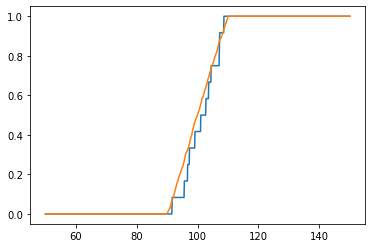

In [125]:
plot_x_range = np.linspace(x_lower_bound, x_upper_bound, x_values_length)
plt.plot(plot_x_range, x_cdf_H0_acc_at_1[:, 1])
plt.plot(plot_x_range, x_cdf_H0_no_acc_at_1[:, 1])

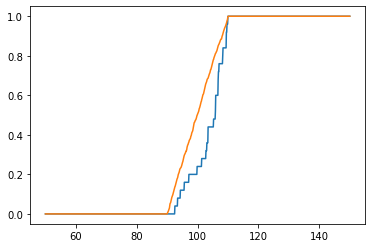

In [126]:
plot_x_range = np.linspace(x_lower_bound, x_upper_bound, x_values_length)
plt.plot(plot_x_range, x_cdf_H1_acc_at_1[:, 1])
plt.plot(plot_x_range, x_cdf_H1_no_acc_at_1[:, 1])

In [133]:
print(max(abs(x_cdf_H0_acc_at_1[:, 1] - x_cdf_H0_no_acc_at_1[:, 1])))
print(max(abs(x_cdf_H1_acc_at_1[:, 1] - x_cdf_H1_no_acc_at_1[:, 1])))

0.17982456140350878
0.3764102564102564


In [124]:
# x_H0_array_acc_at_1

In [58]:
# x_array_H0.shape

In [53]:
# Compare CDFs for both the H0 and H1 cases.

print(compare_CDFs(x_cdf_dict_H0_XT, x_cdf_dict_H0_Xgen))
print(compare_CDFs(x_cdf_dict_H1_XT, x_cdf_dict_H1_Xgen))



0.023797452899257054
0.44796596776235886


# Plots, Part 1:

In [47]:
def generate_aligned_cdf_dict(x_cdf_dict, plot_x_range):
    aligned_cdf_dict = {}
    aligned_cdf_values = []
    for x_value in plot_x_range:
        cdf_value_temp = cdf_value(x_value, x_cdf_dict)
        aligned_cdf_dict[x_value] = cdf_value_temp
        aligned_cdf_values.append(cdf_value_temp)
    
    return aligned_cdf_dict, np.array(aligned_cdf_values)
    

(1001,)
(1001,)


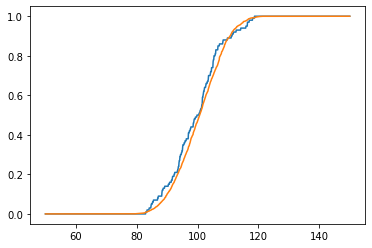

In [48]:
x_lower_bound = 50
x_upper_bound = 150
x_values_length = 1000

plot_x_range = np.linspace(x_lower_bound, x_upper_bound, x_values_length+1)
_, x_cdf_values_H0_XT_aligned = generate_aligned_cdf_dict(x_cdf_dict_H0_XT, plot_x_range)
_, x_cdf_values_H0_Xgen_aligned = generate_aligned_cdf_dict(x_cdf_dict_H0_Xgen, plot_x_range)

# print(x_cdf_dict_H0_Xgen_aligned)
print(x_cdf_values_H0_XT_aligned.shape)
print(plot_x_range.shape)


plt.plot(plot_x_range, x_cdf_values_H0_XT_aligned)
plt.plot(plot_x_range, x_cdf_values_H0_Xgen_aligned)

(1001,)
(1001,)


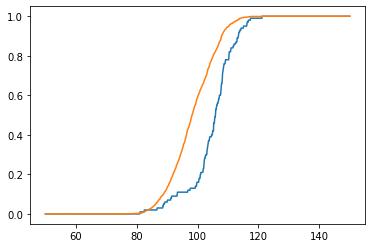

In [49]:
x_lower_bound = 50
x_upper_bound = 150
x_values_length = 1000

plot_x_range = np.linspace(x_lower_bound, x_upper_bound, x_values_length+1)
_, x_cdf_values_H1_XT_aligned = generate_aligned_cdf_dict(x_cdf_dict_H1_XT, plot_x_range)
_, x_cdf_values_H1_Xgen_aligned = generate_aligned_cdf_dict(x_cdf_dict_H1_Xgen, plot_x_range)

# print(x_cdf_dict_H0_Xgen_aligned)
print(x_cdf_values_H1_XT_aligned.shape)
print(plot_x_range.shape)

plt.plot(plot_x_range, x_cdf_values_H1_XT_aligned)
plt.plot(plot_x_range, x_cdf_values_H1_Xgen_aligned)

# Plots, Part 2 - For the paper:

## Our Method:

In [6]:
# N_array = np.linspace(200, 5000, 25)
N_array_1 = np.linspace(10, 90, 9)
N_array_2 = np.linspace(100, 900, 9)
N_array_3 = np.linspace(1000, 5000, 5)
N_array_4 = np.linspace(10000, 50000, 5)
N_array = np.concatenate((N_array_1, N_array_2))
# N_array_our_method = np.concatenate((N_array_1, N_array_2, N_array_3))
# N_array = np.linspace(10000, 50000, 5)

errors_list_our_method = []

for N in list(N_array_our_method):
    N = int(N)
    data_folder_path = "/Users/chih-yuanchiu/Desktop/Code/Causality_Time_Series/data/"
    data_folder_subpath = "p_002_030_ours_3_link/"
#     data_folder_subpath = "p_002_030_naive_3_link/"
    file_name = str(N) + "_error_list.csv"

    df = pd.read_csv(data_folder_path + data_folder_subpath + file_name)
    df_numpy = df.to_numpy()[:, 1:]
    df_avg_error_pair = list(np.mean(df_numpy, axis=0))
    errors_list_our_method.append(df_avg_error_pair)


Text(0, 0.5, 'CDF Gap')

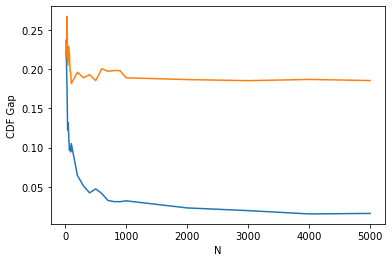

In [8]:
# np.array(errors_list).shape

# plt.plot(N_array, np.array(errors_list)[:, 0])
# plt.plot(N_array, np.array(errors_list)[:, 1])

plt.plot(N_array_our_method, np.array(errors_list_our_method)[:, 0])
plt.plot(N_array_our_method, np.array(errors_list_our_method)[:, 1])
plt.xlabel("N")
# plt.xlabel("log(N)")
plt.ylabel("CDF Gap")



## Naive Aggregation Method:

In [11]:
# N_array = np.linspace(200, 5000, 25)
# N_array_1 = np.linspace(10, 90, 9)
N_array_2 = np.linspace(500, 900, 5)
# N_array_3 = np.linspace(1000, 5000, 5)
# N_array_4 = np.linspace(10000, 50000, 5)
# N_array_naive = np.concatenate((N_array_2, N_array_3))
N_array_naive = N_array_2

errors_list_naive = []

for N in list(N_array_naive):
    N = int(N)
#     print(N)
    data_folder_path = "/Users/chih-yuanchiu/Desktop/Code/Causality_Time_Series/data/"
#     data_folder_subpath = "p_002_030_ours/"
    data_folder_subpath = "p_002_030_naive_3_link/"
    file_name = str(N) + "_error_list_naive.csv"

    df = pd.read_csv(data_folder_path + data_folder_subpath + file_name)
    df_numpy = df.to_numpy()[:, 1:]
    df_avg_error_pair = list(np.mean(df_numpy, axis=0))
    errors_list_naive.append(df_avg_error_pair)


Text(0, 0.5, 'CDF Gap')

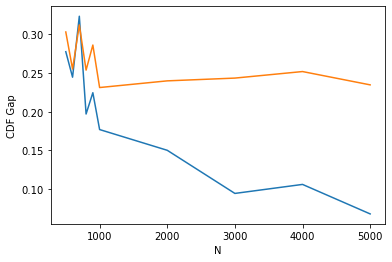

In [12]:
# np.array(errors_list).shape

# plt.plot(N_array, np.array(errors_list)[:, 0])
# plt.plot(N_array, np.array(errors_list)[:, 1])

plt.plot(N_array_naive, np.array(errors_list_naive)[:, 0])
plt.plot(N_array_naive, np.array(errors_list_naive)[:, 1])
plt.xlabel("N")
# plt.xlabel("log(N)")
plt.ylabel("CDF Gap")

## Plots, Together:

In [14]:
# np.ones(100)[-3:]

Text(0, 0.5, 'CDF Gap')

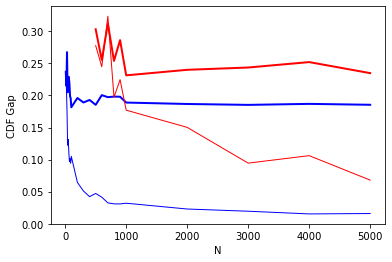

In [15]:
plt.plot(N_array_our_method, np.array(errors_list_our_method)[:, 0], color = 'blue', linewidth=1)
plt.plot(N_array_our_method, np.array(errors_list_our_method)[:, 1], color = 'blue', linewidth=2)
plt.plot(N_array_naive, np.array(errors_list_naive)[:, 0], color = 'red', linewidth = 1)
plt.plot(N_array_naive, np.array(errors_list_naive)[:, 1], color = 'red', linewidth = 2)
plt.xlabel("N")
# plt.xlabel("log(N)")
plt.ylabel("CDF Gap")


In [1]:
# begin_time = time.time()

# x_values_length_set = 10

# x_processed_dict_H1, first_times_dict_H1 = generate_data_processed_dict(x_array_H1, acc_realized_H1)

# # print(x_processed_dict_H1.keys())
# # print()
# # print(first_times_dict_H1.keys())

# # x_processed_dict_H1
# # x_values_jumps_H1 = list(itertools.chain(*list(x_processed_dict_H1.values())))


# print(x_processed_dict_H1.keys())
# print()
# print(first_times_dict_H1.keys())
# print()


# x_values_jumps_H1, cdf_value_at_jumps_H1 = generate_cdf_Xgen(x_processed_dict_H1, first_times_dict_H1, N, T, \
#                                                              num_links = number_of_links, x_values_length = x_values_length_set)

# # print(len(list(itertools.chain(*list(first_times_dict_H1.values())))))

# # end_time = time.time()

# # print("\nTotal time:", end_time - begin_time)




In [3]:
# cdf_value_at_jumps_H1[-1]

# Scratch Work

In [38]:
array_test = np.identity(5)

# column_names = ['One', 'Two', 'Three', 'Four', 'Five']
df = pd.DataFrame(array_test, columns = column_names)

data_folder_path_1 = "/Users/chih-yuanchiu/Desktop/Code/Causality_Time_Series/data/"
file_name = str(N) + ".csv"
data_path = data_folder_path_1 + file_name
df.to_csv(data_path)
